Time Series Analysis

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


In [2]:
# Specify the path to the CSV file
#csv_file = "data/Mastercard_stock_history.csv"


# Read the CSV file into a DataFrame, specifying the index and parsing dates
dataset = pd.read_csv("Desktop/AirPassengers.csv", index_col="Month", parse_dates=["Month"])

# Print the first few rows of the dataset
print(dataset.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [3]:
print(dataset.describe())

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


In [4]:
dataset.isna().sum()

#Passengers    0
dtype: int64

In [5]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [6]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

In [7]:
target = '#Passengers'

In [8]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist() if col != target and col != target)

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Outlier Detection

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

In [9]:
# Extract the first date
first_date = dataset.index[0]
tstart = first_date.replace(year=first_date.year).strftime('%Y-%m-%d')

# Calculate the 60th percentile of the data
quantile_date = dataset.index[int(len(dataset) * 0.7)]
tend = quantile_date.replace(year=quantile_date.year).strftime('%Y-%m-%d')

print("tstart:", tstart)
print("tend:", tend)


tstart: 1949-01-01
tend: 1957-05-01


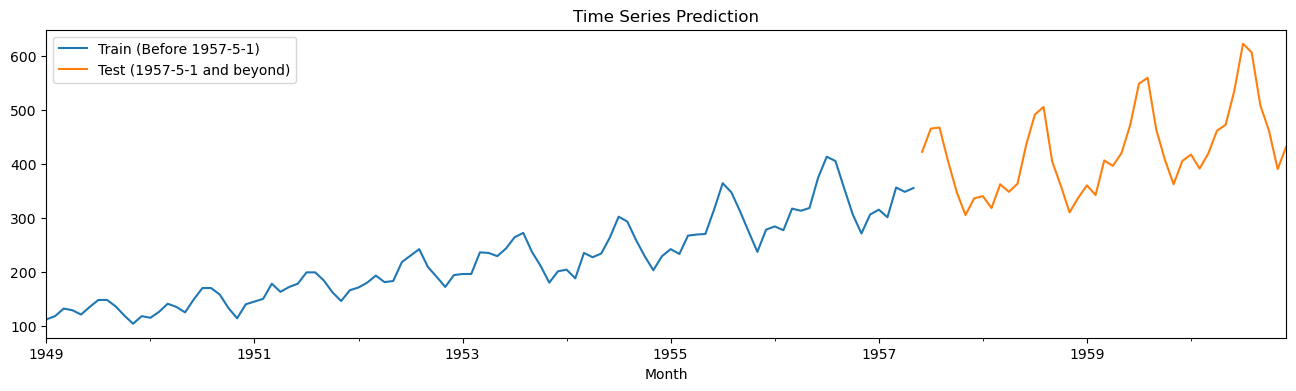

In [10]:
tstart_year = 1949
tstart_month = 1
tstart_day = 1

tend_year = 1957
tend_month = 5
tend_day = 1

def train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    dataset.loc[tstart:tend, target].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].plot(figsize=(16, 4), legend=True)
    
    plt.legend([f"Train (Before {tend})", f"Test ({tend} and beyond)"])
    plt.title("Time Series Prediction")
    plt.show()

train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [11]:
def train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    train = dataset.loc[tstart:tend, target].values
    test = dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].values
    
    return train, test

training_set, test_set = train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [14]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

RNN Model

In [15]:
from tensorflow.keras.layers import SimpleRNN, Dense
# The RNN architecture
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=125, activation="tanh", input_shape=(n_steps, features)))
model_rnn.add(Dense(units=1))
model_rnn.add(Dropout(0.05))

# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

model_rnn.summary()

/Users/jennawilson/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 125)            │        15,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_rnn.fit(X_train, y_train, epochs=200)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0169
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3116e-04 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0342
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0367
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0507
Epoch 16/200
2/

Results

In [22]:
dataset_total = dataset.loc[:,target]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_target= model_rnn.predict(X_test)
#inverse transform the values
predicted_target = sc.inverse_transform(predicted_target)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [23]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Time Series Prediction")
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))



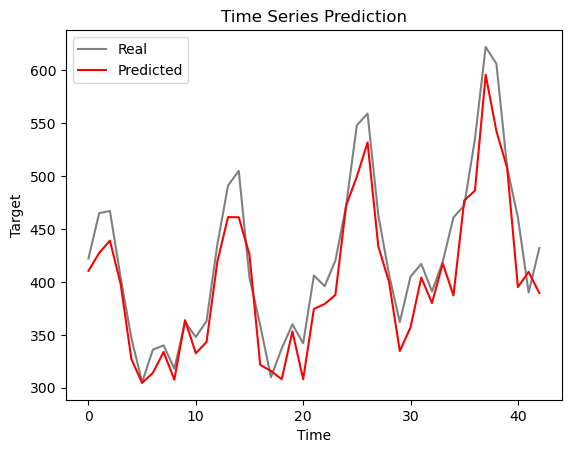

In [24]:
plot_predictions(test_set,predicted_target)

In [25]:
return_rmse(test_set,predicted_target)

The root mean squared error is 30.43.
